# Pokemon with stats: Classification Data Analysis

### 포켓몬 데이터를 이용한 "전설의 포켓몬" 분류 분석하기

속성, 스탯 등 여러가지 데이터가 있는 포켓몬 데이터셋을 이용해서 특정 포켓몬이 `전설의 포켓몬`, 즉 `Legendary`인지 아닌지 분류한다.  
충분한 EDA를 통해 데이터 전체를 명확히 이해하고, 적절한 방법론을 이용해서 분류모델을 생성해 예측 정확도를 최대한 높이는 것을 목표로 한다.

---
---

# Import Modules

먼저 앞으로의 데이터 분석에 필요한 module을 import한다.

In [27]:
import re
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

---
---

# Load Dataset

- 데이터 출처: Kaggle [https://www.kaggle.com/abcsds/pokemon]  


test 데이터 없이 train 데이터만 있으므로, 모델을 생성한 후 퍼포먼스는 train데이터를 적절히 나눠서 확인해야한다.


판다스 모듈을 이용해서 csv파일을 읽어서 앞으로 사용할 수 있도록 `train` 변수에 저장한다.  

In [2]:
train = pd.read_csv("pokemon.csv")
print(train.shape)
train.head()

(800, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


전체 데이터는 **800개**, Feature는 총 **13개**로 구성되어있음을 확인할 수 있다.

이 중 Target 데이터는 `Legendary`이므로,  
`Legendary == True` 값을 가지는 레전드 포켓몬 데이터셋은 `legendary` 변수에,   
`Legendary == False` 값을 가지는 일반 포켓몬 데이터셋은 `ordinary` 변수에 저장해둔다.

In [3]:
legendary = train[train["Legendary"] == True].reset_index(drop=True)
print(legendary.shape)
legendary.head()

(65, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True


In [4]:
ordinary = train[train["Legendary"] == False].reset_index(drop=True)
print(ordinary.shape)
ordinary.head()

(735, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


800개 중 65개의 데이터(약 8.13%) 만 Legendary 포켓몬임을 알 수 있다. 

---
---

# EDA #1: All Columns

가장 먼저 데이터셋이 가지는 column에 대해서 모두 분석해보도록 한다.  
전체 데이터가 800개로 크지 않으므로 최대한 모든 데이터들을 하나하나 이해할 수 있어야 할 것이다.

In [5]:
# train의 컬럼 종류
print(len(train.columns))
train.columns

13


Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

#### 컬럼 설명
- `int` **#** : 포켓몬 Id number. 같은 포켓몬이지만 성별이 다른 경우 등은 같은 #값을 가진다.
- `str` **Name** : 포켓몬 이름. 포켓몬 각각의 이름으로, 이름 데이터는 800개의 포켓몬이 모두 다르다. (unique)
- `str` **Type 1** : 첫 번째 속성. 속성을 하나만 가지는 경우 Type 1에 입력된다. 
- `str` **Type 2** : 두 번째 속성. 속성을 하나만 가지는 포켓몬의 경우 Type 2는 NaN값을 가진다.
- `int` **Total** : 전체 6가지 스탯의 총합. 
- `int` **HP** : 포켓몬의 체력. 
- `int` **Attack** : 물리공격력. (scratch, punch 등) 
- `int` **Defense** : 물리공격에 대한 방어력. 
- `int` **Sp. Atk** : 특수공격력. (fire blast, bubble beam 등) 
- `int` **Sp. Def** : 특수공격에 대한 방어력. 
- `int` **Speed** : 포켓몬 매치에 대해 어떤 포켓몬이 먼저 공격할지를 결정. (더 높은 포켓몬이 먼저 공격한다) 
- `int` **Generation** : 포켓몬의 세대. 현재 데이터에는 6세대까지 있다. 
- `bool` **Legendary** : 전설의 포켓몬 여부. **!! Target feature !!** 

---

## Column#1 `#`

In [6]:
# 총 몇 종류의 #값이 있는지 확인
len(set(train["#"]))

721

전체 데이터는 총 800개인데 `#`컬럼은 그보다 작은 **721개**의 데이터를 가진다.  
즉, #컬럼의 값은 unique하지 않으며(index로 쓸 수 없으며), 같은 번호를 가지는 컬럼들이 있음을 알 수 있다.

In [7]:
# 같은 "#"값을 가지는 포켓몬 example
train[train["#"] == 6]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


예를 들어 #6의 포켓몬은 `Charizard`, `CharizardMega Charizard X`, `CharizardMega Charizard Y` 세 개로 나뉜다.

---

## Column#2 `Name`

In [8]:
# 총 몇 개의 이름이 있는지 확인
len(set(train["Name"]))

800

이름은 데이터셋 전체 값과 같이 800개로, unique함을 알 수 있다.

---

## Column#3 `Type 1` & `Type 2`

모든 포켓몬은 **기본적으로 하나, 또는 최대 두 개까지** 속성을 가질 수 있다.  
데이터 셋에는 하나만을 가지는 포켓몬은 `Type 1`에만 속성이 표시되고 `Type 2`에는 NaN값이 들어가 있다. 


속성의 종류는 총 몇 가지인지 알아보자.

In [9]:
len(list(set(train["Type 1"]))), len(list(set(train["Type 2"])))

(18, 19)

`Type 1`에는 총 18가지, `Type 2`에는 총 19가지의 속성이 들어가 있는데, 여기서 `Type 2`가 한 가지 더 많은 것은

In [10]:
set(train["Type 2"]) - set(train["Type 1"])

{nan}

`Nan`값임을 알 수 있고, 따라서 그 외의 나머지 18가지 속성은 같은 종류로 데이터가 들어가 있음을 알 수 있다.

In [11]:
# 모든 타입을 types 변수에 저장
types = list(set(train["Type 1"]))
print(types)

['Poison', 'Electric', 'Dark', 'Water', 'Fighting', 'Flying', 'Ice', 'Ghost', 'Ground', 'Grass', 'Steel', 'Psychic', 'Rock', 'Fairy', 'Bug', 'Fire', 'Dragon', 'Normal']


In [12]:
# Type 2가 NaN값인 데이터의 개수
len(train[train["Type 2"].isna()])

386

총 386개의 포켓몬은 속성을 하나만 가지고, 나머지는 두 개의 속성을 가진다.

#### `Type 1` 데이터 분포 plot
Legendary를 기준으로 각 type에 어떻게 포켓몬이 분포되어있는지 확인해보자.

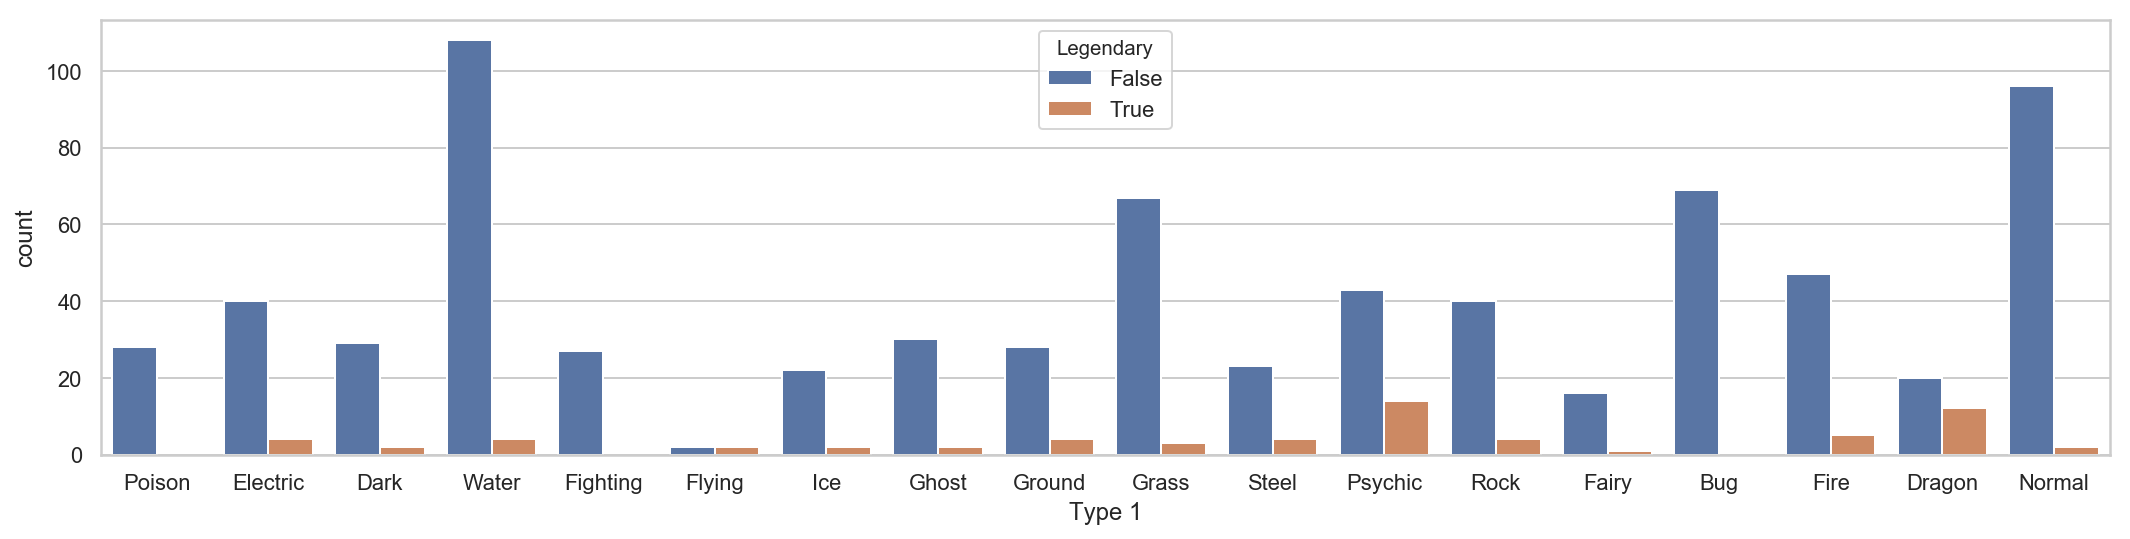

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)

sns.countplot(data=train, x="Type 1", hue="Legendary", order=types)
plt.show()

피벗테이블로 각 속성에 Legendary 포켓몬들이 몇 퍼센트씩 있는지 확인해보자.

In [14]:
pd.pivot_table(train, index="Type 1", values="Legendary").sort_values(by=["Legendary"], ascending=False).T

Type 1,Flying,Dragon,Psychic,Steel,Ground,Fire,Electric,Rock,Ice,Dark,Ghost,Fairy,Grass,Water,Normal,Poison,Fighting,Bug
Legendary,0.5,0.375,0.245614,0.148148,0.125,0.096154,0.090909,0.090909,0.083333,0.064516,0.0625,0.058824,0.042857,0.035714,0.020408,0.0,0.0,0.0


Legendary비율이 가장 높은 속성은 **Flying**으로, 50퍼센트의 비율을 갖는다. 전설의 포켓몬들은 많이 날라다님을 알 수 있다..!

#### `Type 2` 데이터 분포 plot

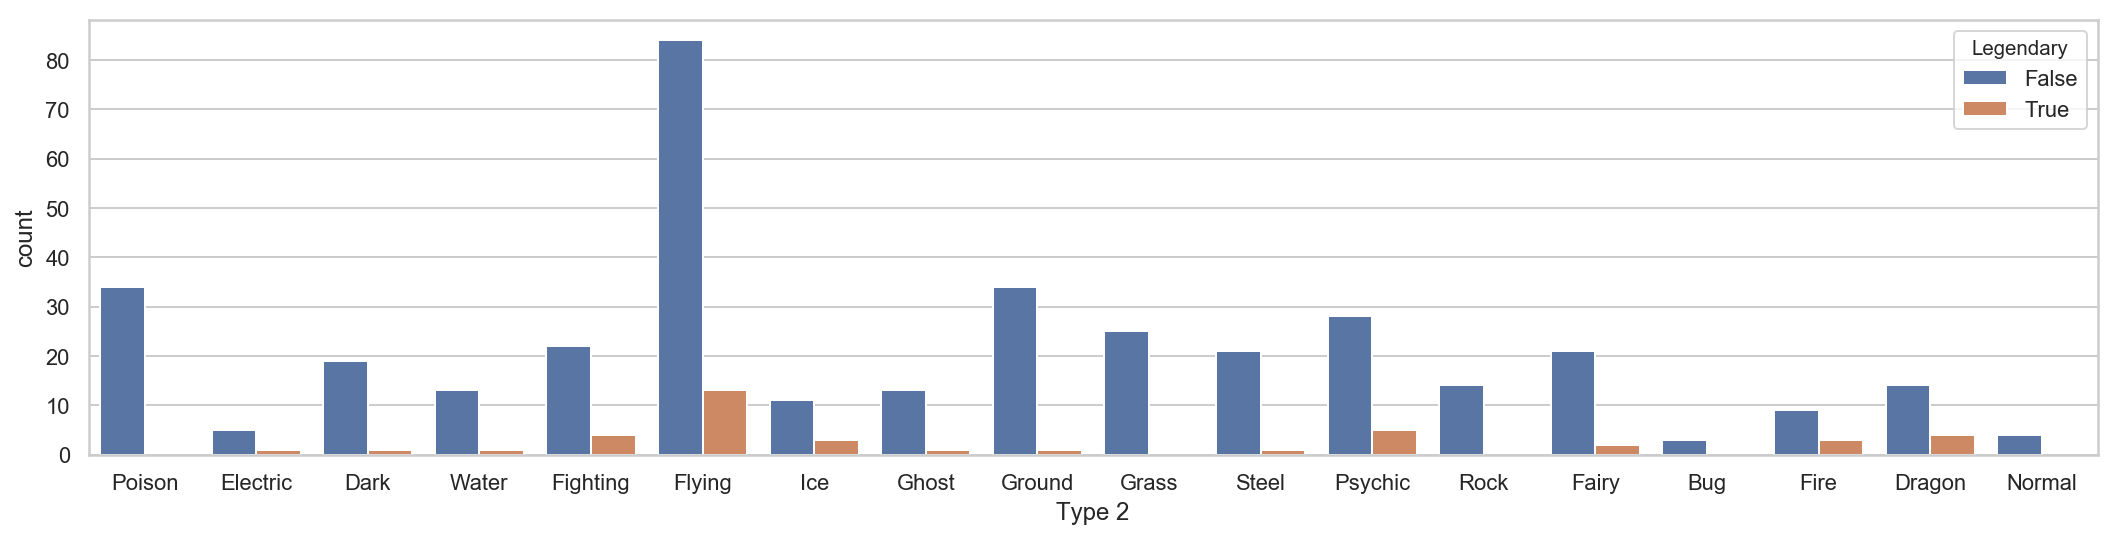

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)

sns.countplot(data=train, x="Type 2", hue="Legendary", order=types)
plt.show()

In [16]:
pd.pivot_table(train, index="Type 2", values="Legendary").sort_values(by=["Legendary"], ascending=False).T

Type 2,Fire,Dragon,Ice,Electric,Fighting,Psychic,Flying,Fairy,Water,Ghost,Dark,Steel,Ground,Rock,Bug,Poison,Normal,Grass
Legendary,0.25,0.222222,0.214286,0.166667,0.153846,0.151515,0.134021,0.086957,0.071429,0.071429,0.05,0.045455,0.028571,0.0,0.0,0.0,0.0,0.0


Type 1때보다 숫자는 낮아졌으나, 역시 **Flying**속성 포켓몬의 Legendary 비율이 25%로 가장 높다.

---

## Column#4 `Total`

데이터셋에서 포켓몬은 총 6가지의 스탯값을 가지고, Total 컬럼은 이 6가지 속성값의 총 합이다. 

In [17]:
# 모든 스탯을 stats 변수에 저장
stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]

In [18]:
# 확인
print("#1 pokemon - {}".format(train[train["#"] == 1]["Name"].values), \
      "\ntotal: ", int(train[train["#"] == 1]["Total"]), "\tstats: ", list(train[train["#"] == 1][stats].values[0]), \
      "\nsum_stats: ", sum(list(train[train["#"] == 1][stats].values[0])), \
      "\n\n(total == sum_stats): ", int(train[train["#"] == 1]["Total"]) == sum(list(train[train["#"] == 1][stats].values[0])))
train[train["#"] == 1]

#1 pokemon - ['Bulbasaur'] 
total:  318 	stats:  [45, 49, 49, 65, 65, 45] 
sum_stats:  318 

(total == sum_stats):  True


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False


위와 같이 Total값은 6개의 스탯을 모두 더한 값이 맞음을 확인했다.  
모델을 만들어 분석할 때 **Feature 중 선형관계를 가지는 컬럼이 있다면 다중공선성이 생길 수 있으므로** 나중에 Total 컬럼은 제외하도록 한다.

#### `Total`값에 따른 분포 plot

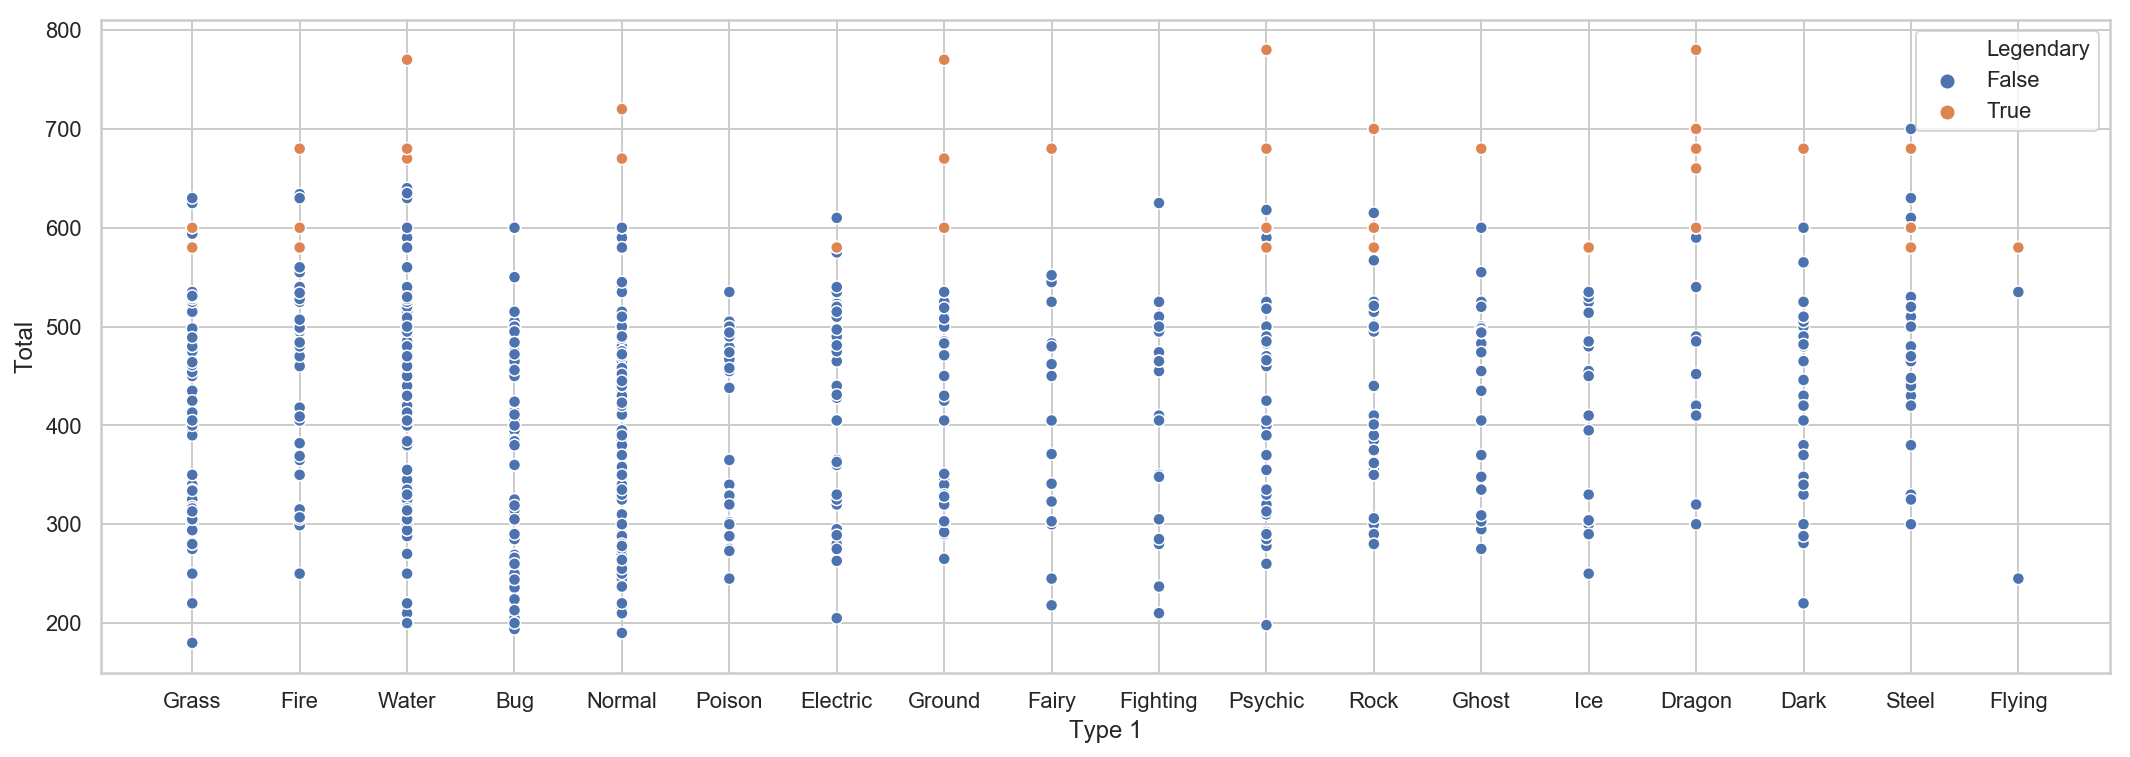

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)

sns.scatterplot(data=train, x="Type 1", y="Total", hue="Legendary")
plt.show()

Type 1별로 Total 값을 확인했을 때, **Legendary 포켓몬은 주로 Total stat 값이 높음을 확인**하였다. 전설의 포켓몬 왕쎔..!!

---

## Column#5 STATS: `HP`, `Attack`, `Defense`, `Sp. Atk`, `Sp. Def`, `Speed`

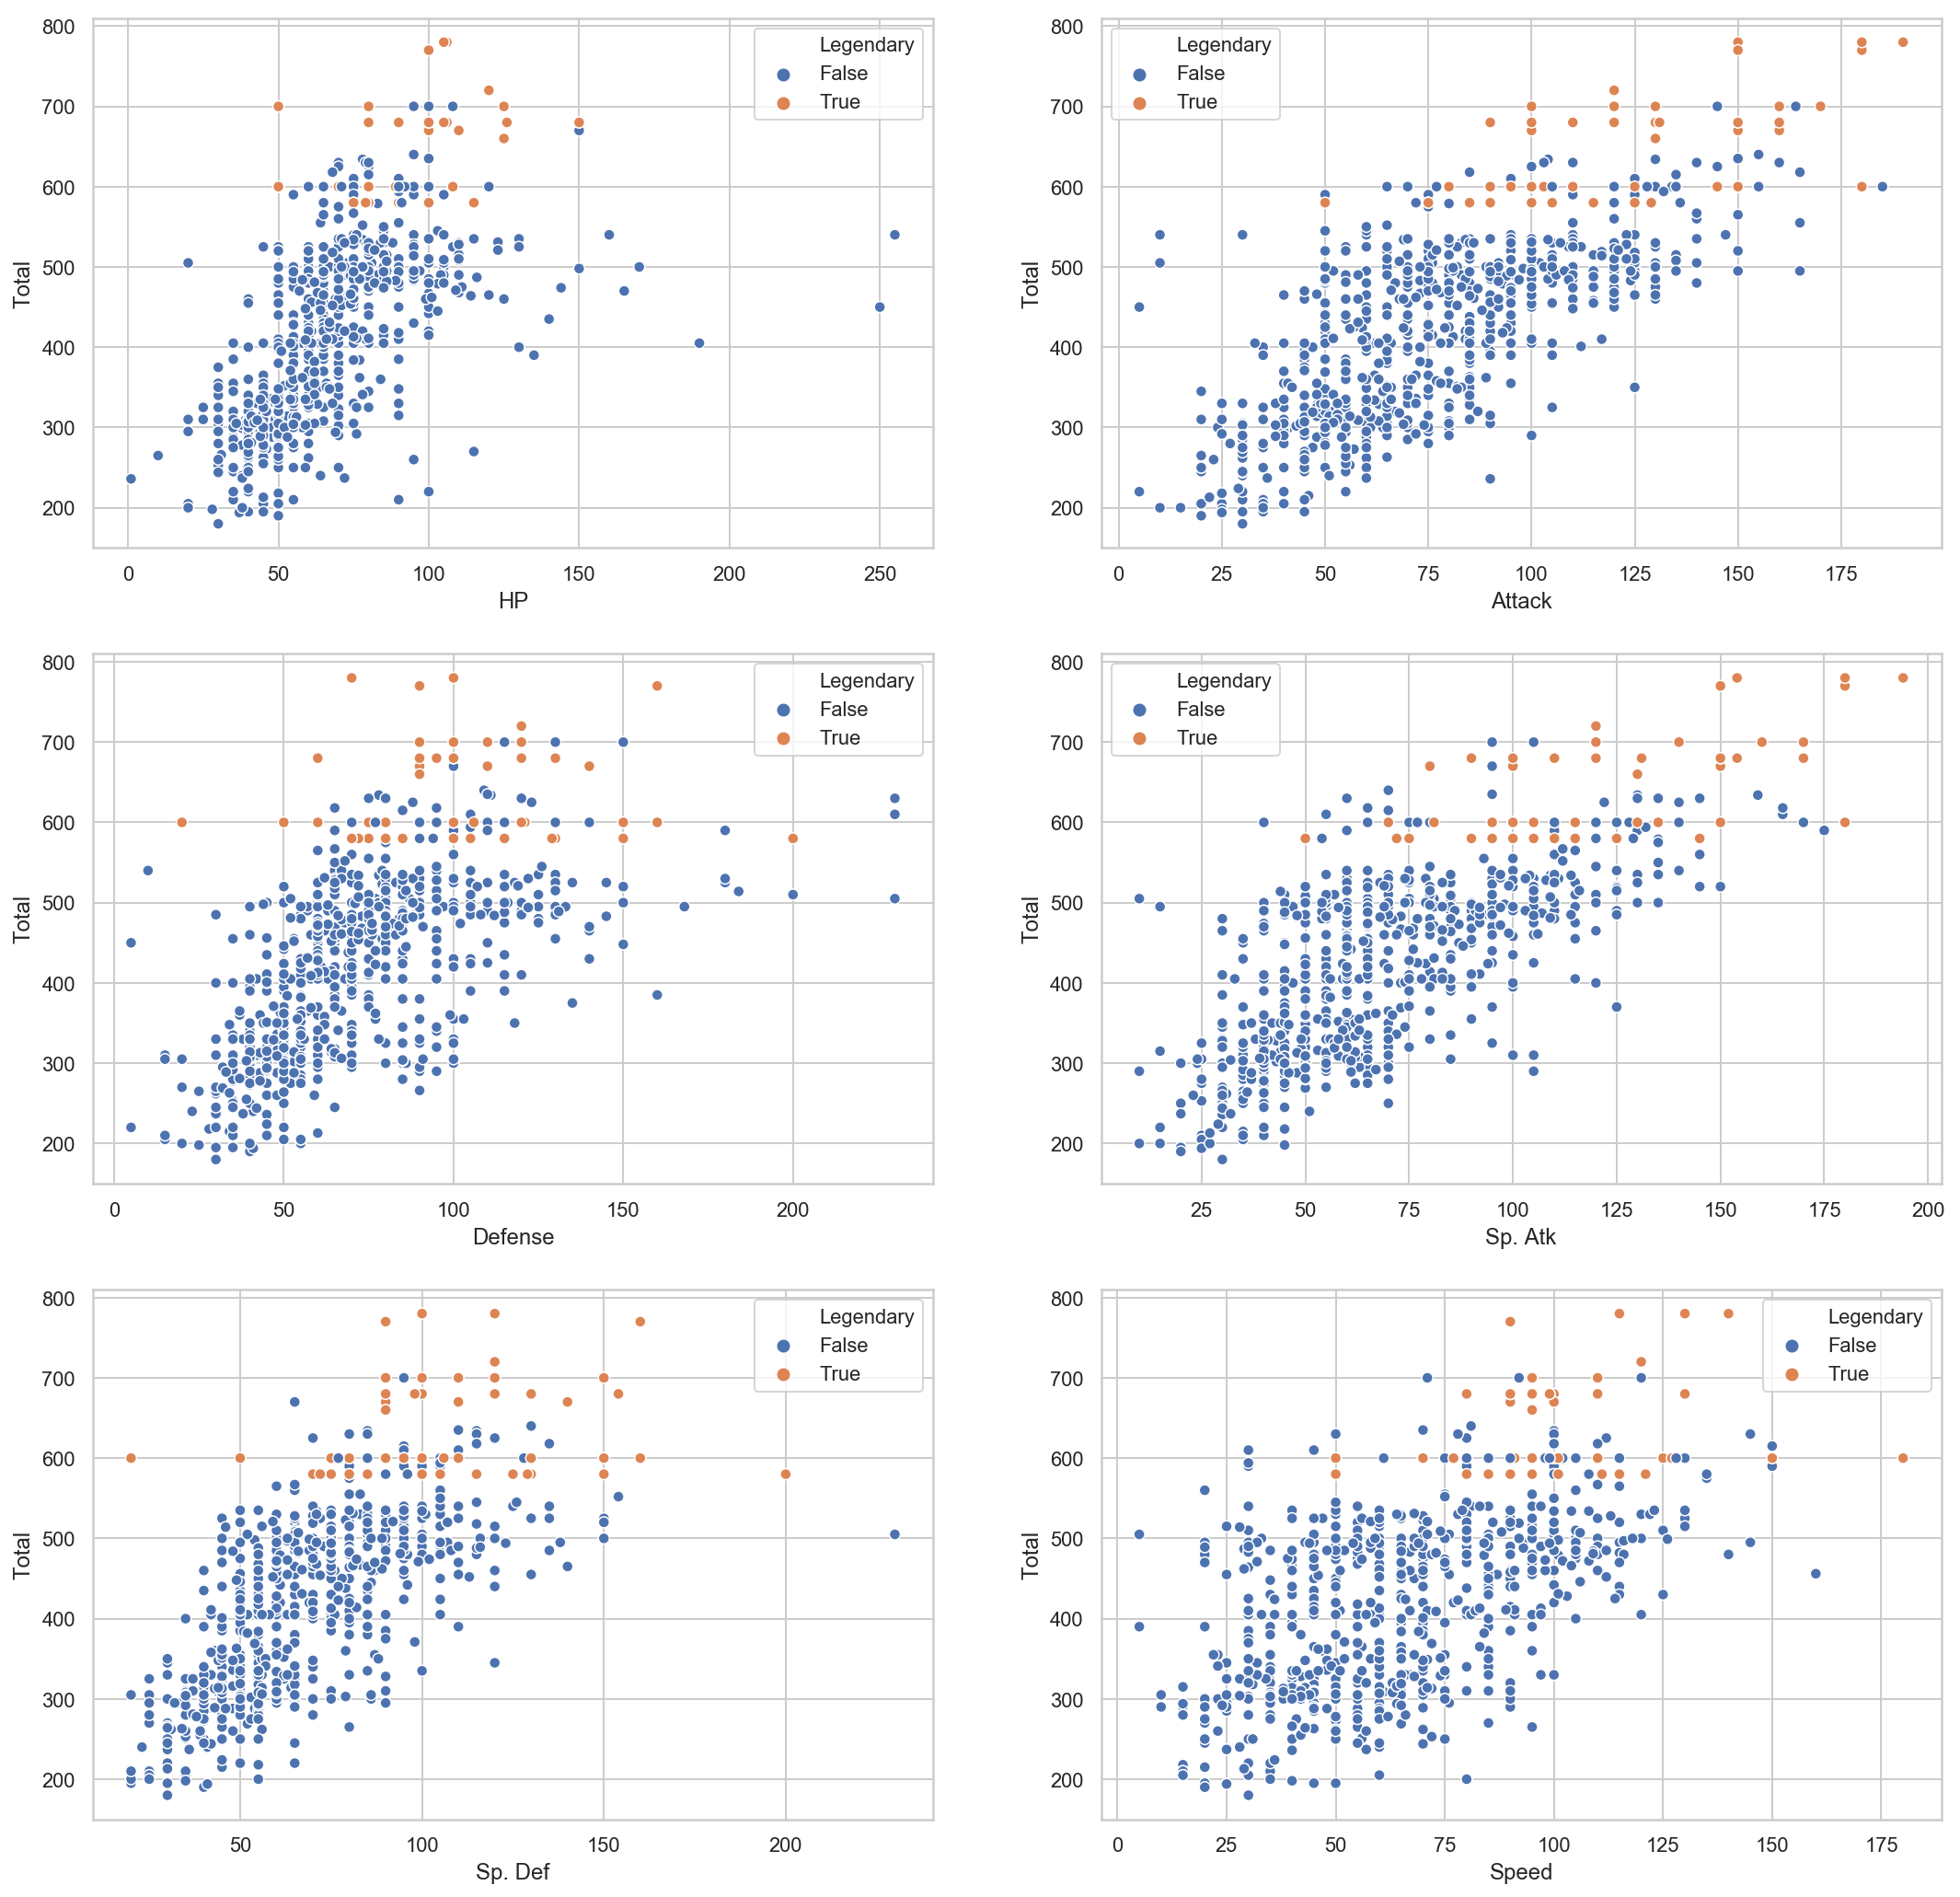

In [20]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(18, 18)

sns.scatterplot(data=train, y="Total", x="HP", hue="Legendary", ax=ax1)
sns.scatterplot(data=train, y="Total", x="Attack", hue="Legendary", ax=ax2)
sns.scatterplot(data=train, y="Total", x="Defense", hue="Legendary", ax=ax3)
sns.scatterplot(data=train, y="Total", x="Sp. Atk", hue="Legendary", ax=ax4)
sns.scatterplot(data=train, y="Total", x="Sp. Def", hue="Legendary", ax=ax5)
sns.scatterplot(data=train, y="Total", x="Speed", hue="Legendary", ax=ax6)
plt.show()

#### 각 스탯에 대한 분석

- **`HP`, `Defense`, `Sp. Def`**
    - 전설의 포켓몬은 주로 높은 스탯들을 갖지만, 이 세 가지에서는 일반포켓몬이 전설의 포켓몬보다 특히 높은 몇몇 포켓몬이 있었다.   
    그러나 그 포켓몬들도 Total값은 특별히 높지 않은 것으로 보아 특정 스탯만 특별히 높은, 즉 특정 속성에 특화된 포켓몬들로 보인다.   
    (ex. 방어형, 공격형 등)
    
    
- **`Attack`, `Sp. Atk`, `Speed`**
    - 이 세 가지 스탯은 Total과 거의 비례하는 양상을 띈다. 주로 전설의 포켓몬이 가장 높은 값들 또한 가진다.

---

## Column#6 `Generation`

Generation은 각 포켓몬의 "세대"로, 현재 데이터셋에는 1~6세대의 포켓몬이 존재한다.  
각 세대에 대한 포켓몬의 수를 확인해 보자.

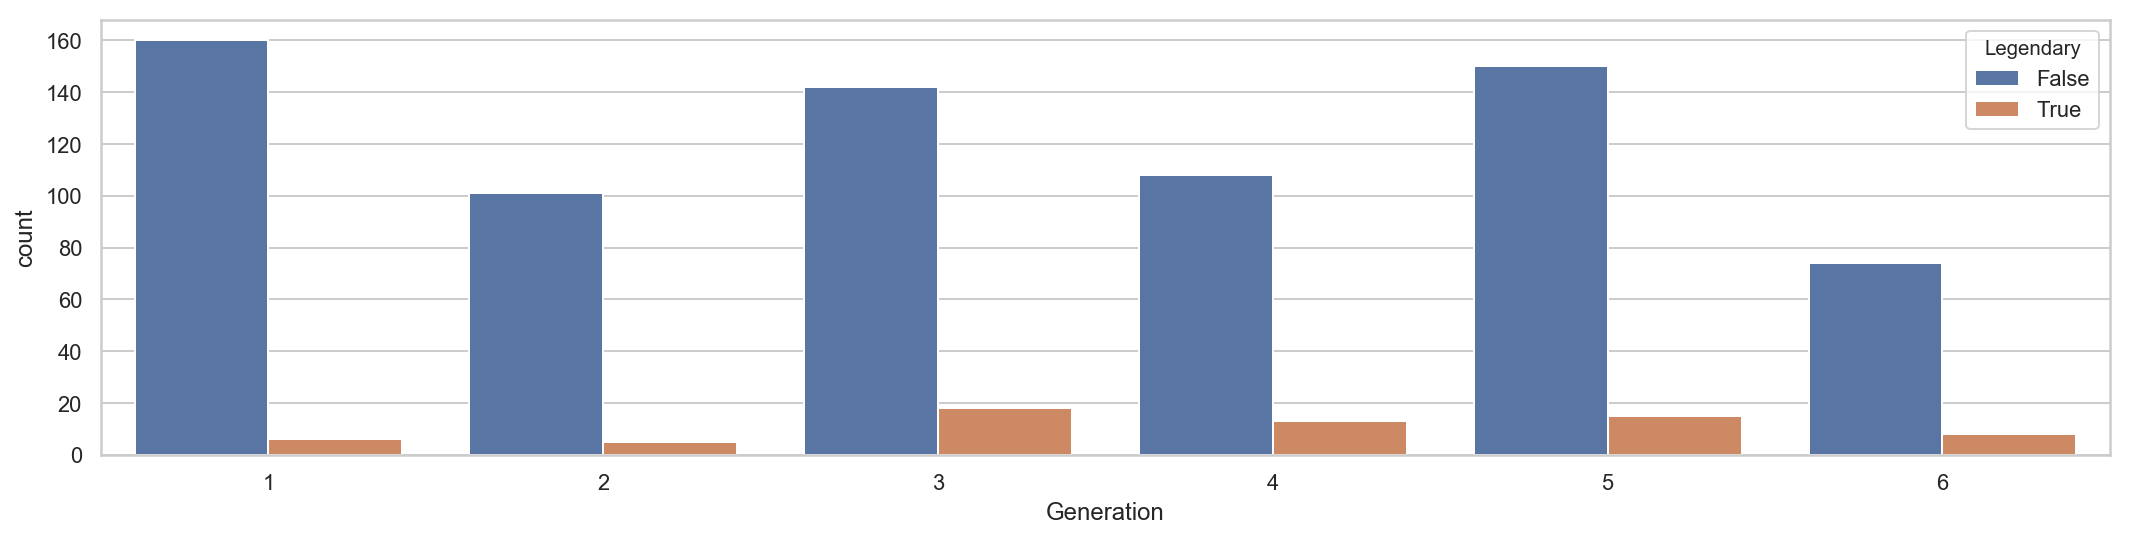

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)

sns.countplot(data=train, x="Generation", hue="Legendary")
plt.show()

In [22]:
# 표로 개수 확인
train.groupby("Generation").size().reset_index(name="counts").T

,0,1,2,3,4,5
Generation,1,2,3,4,5,6
counts,166,106,160,121,165,82


1세대부터 6세대까지, 6세대를 제외하고는 비교적 고르게 분포해있음을 알 수 있다.  
세대에 따른 Legendary 포켓몬의 분포가 특별한 경향을 보이는 것 같지는 않다.

---
---

# EDA #2: Legendary / Ordinary Pokemon - Details

모든 컬럼에 대해 확인하였으니, 이제 특별히 Legendary 포켓몬 또는 Ordinary 포켓몬들을 분리해서 개별로 분석해본다.   
전설의 포켓몬 또는 일반 포켓몬 각각이 가지는 특징들을 세분화해서 확인해볼 필요가 있다.

## Details#1 `Total` value of Legendary Pokemons

먼저 전설의 포켓몬들의 속성 Total값을 확인해보자.

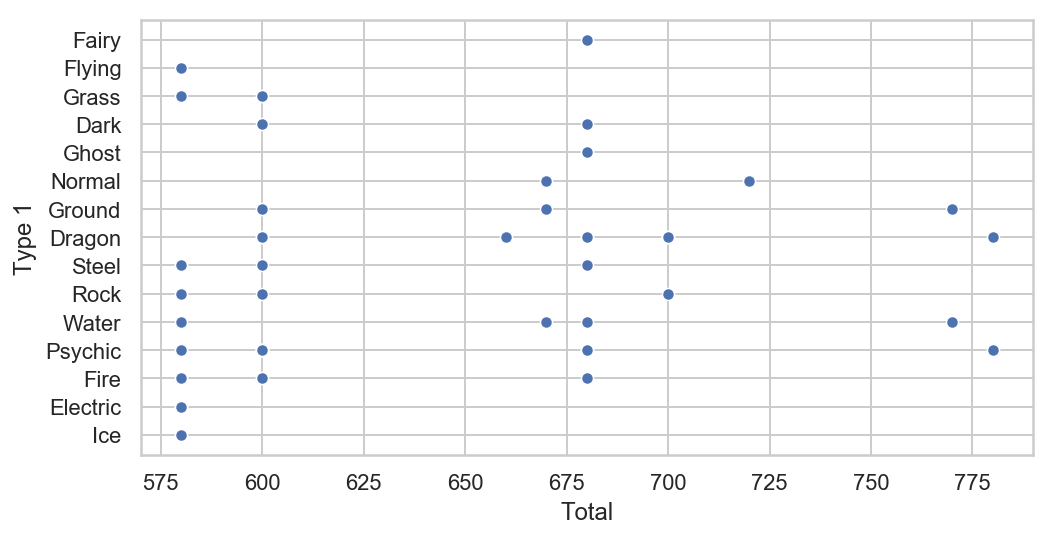

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

sns.scatterplot(data=legendary, y="Type 1", x="Total")
plt.show()

여기서 한 가지 짚고 넘어가야 할 점이 보인다.  


: **전설의 포켓몬들의 Total값들이 특정 점에 몰려있다**는 것이다. 실제로 전설의 포켓몬이 가지는 Total값들의 집합을 확인해보자.

In [24]:
print(sorted(list(set(legendary["Total"]))), ": ", len(set(legendary["Total"])))

[580, 600, 660, 670, 680, 700, 720, 770, 780] :  9


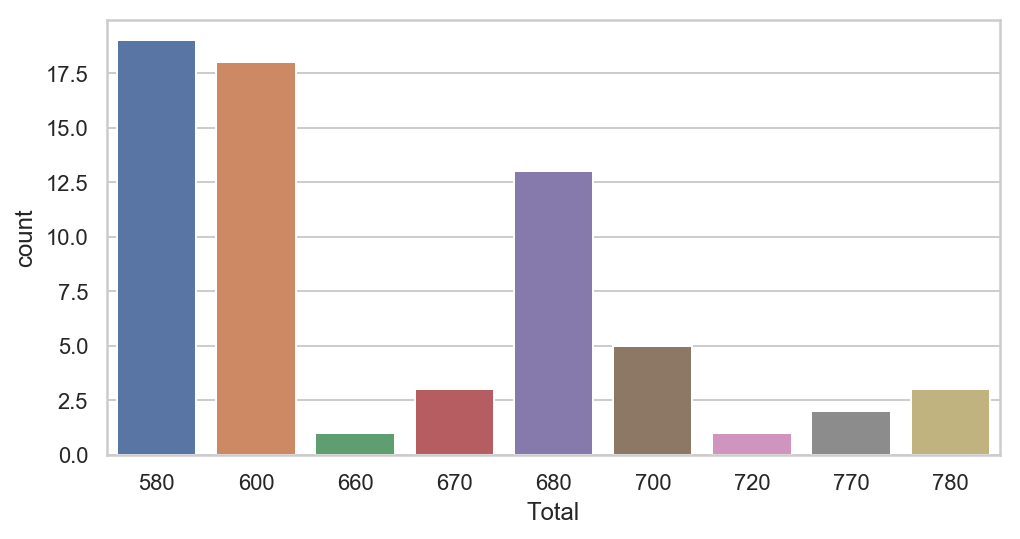

In [25]:
# 전설의 포켓몬이 가지는 Total값에 대한 포켓몬 수 확인
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

sns.countplot(data=legendary, x="Total")
plt.show()

In [26]:
round(65 / 9, 2)

7.22

**약 7.22마리끼리는 같은 Total 스탯값을 가진다**는 의미이다. 이는 언뜻 봐도 꽤.. 높은 값인 것 같은 느낌을 준다.

이러한 높은 값이 전설의 포켓몬에만 해당하는 것인지, 느낌이 실제로 맞는지를 확인하기 위해 ordinary에서도 같은 방법으로 다시 확인해보자.

In [27]:
print(sorted(list(set(ordinary["Total"]))), ": ", len(set(ordinary["Total"])))

[180, 190, 194, 195, 198, 200, 205, 210, 213, 215, 218, 220, 224, 236, 237, 240, 244, 245, 250, 251, 253, 255, 260, 262, 263, 264, 265, 266, 269, 270, 273, 275, 278, 280, 281, 285, 288, 289, 290, 292, 294, 295, 299, 300, 302, 303, 304, 305, 306, 307, 308, 309, 310, 313, 314, 315, 316, 318, 319, 320, 323, 325, 328, 329, 330, 334, 335, 336, 340, 341, 345, 348, 349, 350, 351, 352, 355, 358, 360, 362, 363, 365, 369, 370, 371, 375, 380, 382, 384, 385, 390, 395, 400, 401, 405, 409, 410, 411, 413, 414, 415, 418, 420, 423, 424, 425, 428, 430, 431, 435, 438, 440, 442, 445, 446, 448, 450, 452, 454, 455, 456, 458, 460, 461, 462, 464, 465, 466, 467, 468, 470, 471, 472, 473, 474, 475, 479, 480, 481, 482, 483, 484, 485, 487, 488, 489, 490, 494, 495, 497, 498, 499, 500, 505, 507, 508, 509, 510, 514, 515, 518, 519, 520, 521, 523, 525, 528, 530, 531, 534, 535, 540, 545, 550, 552, 555, 560, 565, 567, 575, 579, 580, 590, 594, 600, 610, 615, 618, 625, 630, 634, 635, 640, 670, 700] :  195


일반포켓몬은 총 195가지의 Total 속성값을 가지고, 전체 일반포켓몬은 (800 - 65), 즉 735마리이므로,

In [28]:
round(735 / 195, 2)

3.77

**약 3.77마리만 같은 Total 스탯값을 가진다.**   

　    

  
이로써 다음 두 가지를 알 수 있다.

- Total값의 다양성은 일반포켓몬이 전설의 포켓몬보다 두 배 가까이 가진다, 즉 전설의 포켓몬의 Total값은 다양하지 않다.   
    : **total 속성값이 전설의 포켓몬의 값들의 집합에 포함되는지의 여부**는 전설의 포켓몬임을 결정하는 데에 영향을 미친다.



- 또한, **전설의 포켓몬의 Total값 중에는 일반포켓몬이 가지지 못하는 Total값이 존재**한다. ex) 680, 720, 770, 780  
    : Total값은 전설의 포켓몬인지 아닌지의 여부를 결정하는 데에 이러한 방식으로도 영향을 미칠 수 있다.  
　

     
즉, **Total값은 target을 예측하는 데에 유효한 컬럼일 것**이라는 결론을 내릴 수 있다.


　



따라서 데이터 전처리 시에 생각해야 하는 부분이 한 가지 생긴다.   
위에서 컬럼을 분석하면서 Total값과 6가지의 스탯값은 서로 다음의 식을 만족하면서 선형 종속의 관계를 가짐을 확인하였다.

$$ Total  =  HP  +  Attack  +  Defense  +  Sp. Atk  +  Sp. Def  +  Speed $$

즉, Total값은 서로 다른 6가지의 속성값을 모두 더한 값이기 때문에 다중공선성을 방지하기 위해서는 위의 7가지 값 중 한 가지를 제거해야 했다.   

이 때 가장 간단한 방법으로는 모든 속성값의 합인 Total값을 지울 수 있지만,    
**Total값은 target을 예측하는 데에 유효한 컬럼이라는 결론을 내렸으므로 Total값 대신 다른 6가지의 스탯 중 한 가지를 제거**하기로 한다.

---

## Details#2 `Name` of Legendary Pokemons

데이터를 보고 있으면 한 가지 더 특이한 점이 있다. 바로 **이름!**  
전설의 포켓몬들의 이름을 보면, **특정 단어가 들어가있는 이름**, 또는 **긴 이름**을 가진 경우가 많음을 확인할 수 있다.

#### 특정 단어가 들어가있는 이름

In [29]:
# 바로 확인해보자

# 이름이 비슷한 전설의 포켓몬들의 모임 names
n1, n2, n3, n4, n5 = legendary[3:6], legendary[14:24], legendary[25:29], legendary[46:50], legendary[52:57]
names = pd.concat([n1, n2, n3, n4, n5]).reset_index(drop=True)

먼저, 전설의 포켓몬 중에는 이름이 한 이름에서 파생되어 만들어진 이름들이 있다. 

In [30]:
# 이름이 세트로 지어져있는 포켓몬들의 모임 set_names
sn1, sn2 = names[:13], names[23:]
set_names = pd.concat([sn1, sn2]).reset_index(drop=True)
set_names

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
1,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True
2,150,MewtwoMega Mewtwo Y,Psychic,NaN,780,106,150,70,194,120,140,1,True
3,380,Latias,Dragon,Psychic,600,80,80,90,110,130,110,3,True
4,380,LatiasMega Latias,Dragon,Psychic,700,80,100,120,140,150,110,3,True
5,381,Latios,Dragon,Psychic,600,80,90,80,130,110,110,3,True
6,381,LatiosMega Latios,Dragon,Psychic,700,80,130,100,160,120,110,3,True
7,382,Kyogre,Water,NaN,670,100,100,90,150,140,90,3,True
8,382,KyogrePrimal Kyogre,Water,NaN,770,100,150,90,180,160,90,3,True
9,383,Groudon,Ground,NaN,670,100,150,140,100,90,90,3,True


이들은 모두 세트로 이름이 지어져 있다.   
- **"MewTwo", "Latias", "Latios", "Kyogre", "Groudon", "Rayquaza", "Kyurem"** 등의 이름에서부터 그 앞에 성이 붙여지는 식이다.   

또는, 이름에 forme가 들어가는 여러가지 전설의 포켓몬이 있는 경우도 존재한다.

In [31]:
# 전설의 포켓몬 가족 forme
formes = names[13:23]
formes

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
13,386,DeoxysNormal Forme,Psychic,NaN,600,50,150,50,150,50,150,3,True
14,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True
15,386,DeoxysDefense Forme,Psychic,NaN,600,50,70,160,70,160,90,3,True
16,386,DeoxysSpeed Forme,Psychic,NaN,600,50,95,90,95,90,180,3,True
17,641,TornadusIncarnate Forme,Flying,NaN,580,79,115,70,125,80,111,5,True
18,641,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,True
19,642,ThundurusIncarnate Forme,Electric,Flying,580,79,115,70,125,80,111,5,True
20,642,ThundurusTherian Forme,Electric,Flying,580,79,105,70,145,80,101,5,True
21,645,LandorusIncarnate Forme,Ground,Flying,600,89,125,90,115,80,101,5,True
22,645,LandorusTherian Forme,Ground,Flying,600,89,145,90,105,80,91,5,True


이렇게 이름에 forme가 들어가면 이는 전설의 포켓몬일 확률이 아주 높다는 것을 확인하였다.

#### 긴 이름

전설의 포켓몬은 위와 비슷한 이유로, 이름의 길이도 주로 긴 경우가 많다.   
데이터셋에 이름 길이 컬럼을 생성해서 비교해보도록 하자.

In [32]:
# legendary에 이름 길이 컬럼 생성
legendary["name_count"] = 0

for i in range(len(legendary)):
    legendary["name_count"][i] = len(legendary["Name"][i])
    
legendary.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True,8
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True,6
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True,7
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,6
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True,19


In [33]:
# ordinary에 이름 길이 컬럼 생성
ordinary["name_count"] = 0

for i in range(len(ordinary)):
    ordinary["name_count"][i] = len(ordinary["Name"][i])
    
ordinary.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


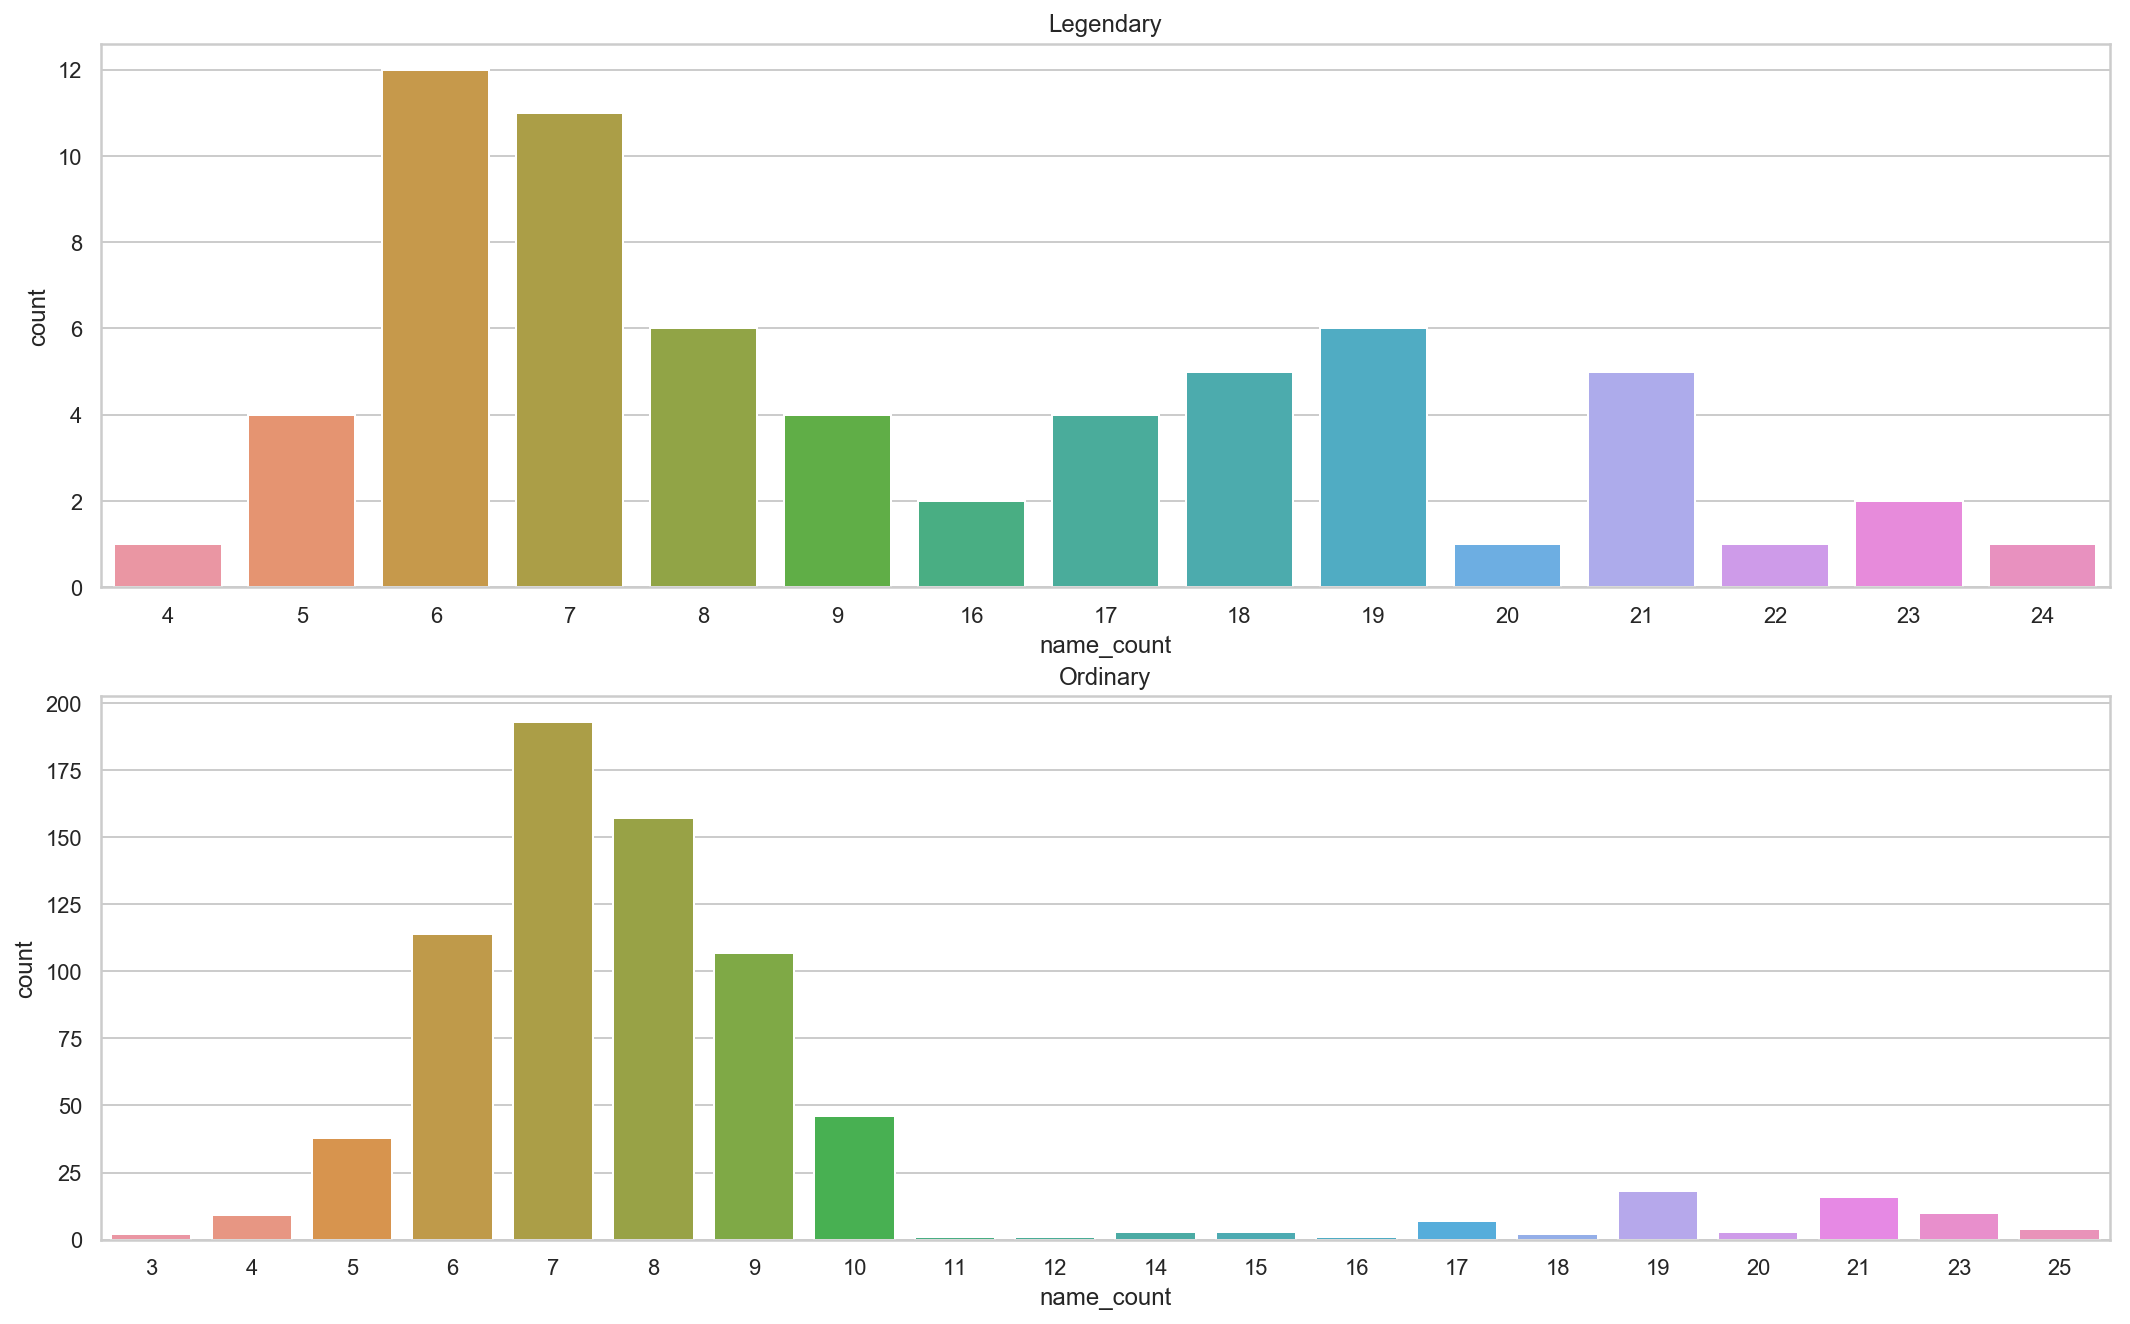

In [34]:
figure, ((ax1), (ax2)) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 11)

sns.countplot(data=legendary, x="name_count", ax=ax1).set_title("Legendary")
sns.countplot(data=ordinary, x="name_count", ax=ax2).set_title("Ordinary")
plt.show()

위에서 볼 수 있듯이,    
**전설의 포켓몬은 16 이상의 긴 이름을 가진 포켓몬이 많은** 반면, **일반 포켓몬은 10 이상의 길이를 가지는 이름의 빈도가 아주 낮다.**

In [35]:
# 전설의 포켓몬의 이름이 10 이상일 확률
print(round(len(legendary[legendary["name_count"] > 9]) / len(legendary) * 100, 2), "%")

41.54 %


In [36]:
# 일반 포켓몬의 이름이 10 이상일 확률
print(round(len(ordinary[ordinary["name_count"] > 9]) / len(ordinary) * 100, 2), "%")

15.65 %


**전설의 포켓몬의 이름이 10 이상일 확률은 41%**를 넘는 반면, **일반포켓몬의 이름이 10 이상일 확률은 약 16%**밖에 안됨을 확인할 수 있다.    
이는 아주 큰 차이이므로 target을 구분하는데에 큰 의미를 가진다.

- 위의 두 가지, 이름에 대한 분석은 중요한 시사점을 가진다.   

    : **만약 "Latios"가 전설의 포켓몬이라면, "%%% Latios" 또한 전설의 포켓몬이다!   
    : 적어도 전설의 포켓몬에서 높은 빈도를 보이는 이름들의 모임이 존재한다!  
    : 전설의 포켓몬은 긴 이름을 가졌을 확률이 높다!**
    
따라서 데이터를 전처리할 때 이름에 있는 토큰, 그리고 이름의 길이 등을 잘 종합해서 target을 맞추는 데에 활용할 수 있도록 하자.

---

# Data PreProcessing

지금까지의 EDA를 바탕으로, 모델에 데이터를 돌리기 위해 다음과 같은 세 가지 전처리를 해야한다.

- **`Name`** : 문자열 데이터를 EDA 결과에 따라 적절히 처리하기

        
- **`Type 1` & `Type 2`** : 무슨 Type를 가지냐에 따라 categorical 데이터로 변환하기
    

- **stats: 다중공선성 방지** : 선형종속 관계를 가지는 7가지 컬럼 (Total + 6가지스탯) 중 한 가지 삭제하기


## Preprocessing#1 `Name`

이름에 관해서는 두 가지를 생각해야한다.   
      
**1. 이름의 길이** : `name_count` 컬럼을 생성 후 길이가 10을 넘는지 아닌지에 대한 categorical 컬럼을 생성
    
    
**2. 토큰 추출** : legendary 포켓몬에서 많이 등장하는 토큰을 추려내고 토큰 포함 여부를 one-hot-encoding 한다.

#### 이름의 길이

이름의 길이를 확인할 수 있는 `name_count` 컬럼을 생성한다.

In [37]:
# train 데이터에 name_count 생성
train["name_count"] = 0

for i in range(len(train)):
    train["name_count"][i] = len(train["Name"][i])
    
train.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


이름의 길이가 10 이상이면 True, 미만이면 False을 가지는 `long_name` 컬럼을 생성한다.

In [38]:
train["long_name"] = train["name_count"] > 9
train.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True


이름의 길이에 대해서는 `name_count`, `long_name` 두 가지 컬럼에 대해서 모든 경우의 수에 따라 모델을 학습시켜볼 것이다.

#### 토큰 추출

토큰을 추출하기에 앞서, 포켓몬의 이름에 대해 먼저 알아보자.  


포켓몬의 이름은 총 네 가지 타입으로 나뉜다.
   - 한 단어인 경우
   - 두 단어이고, 앞 단어는 두 개의 대문자를 가지며 대문자를 기준으로 두 부분으로 나뉘는 경우
   - 이름은 두 단어이고, 맨 뒤에 X, Y로 성별을 표시하는 경우
   - 알파벳이 아닌 문자를 포함하는 경우

이 중 가장 먼저 알파벳이 아닌 문자를 포함하는 경우를 처리하도록 하자.

In [39]:
# 이름이 알파벳이 아닌 문자를 포함하는지 확인하기 위해 `name_isalpha` 컬럼을 생성
train["name_isalpha"] = True

for i in range(len(train)):
    train["name_isalpha"][i] = train["Name"][i].replace(" ", "").isalpha()

In [40]:
print(train[train["name_isalpha"] == False].shape)
train[train["name_isalpha"] == False]

(9, 16)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,name_isalpha
34,29,Nidoran♀,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,False
37,32,Nidoran♂,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,False
90,83,Farfetch'd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,False
131,122,Mr. Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,False
252,233,Porygon2,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,False
270,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,False
487,439,Mime Jr.,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,False
525,474,Porygon-Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,False
794,718,Zygarde50% Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,False


이름에 알파벳이 아닌 것을 포함하는 경우는 9마리 뿐이므로, 직접 이름을 바꿔주도록 하자.

In [41]:
# 직접 9개의 row를 위의 세 가지 타입에 각각 들어갈 수 있도록 변환
train = train.replace(to_replace="Nidoran♀", value="Nidoran X")
train = train.replace(to_replace="Nidoran♂", value="Nidoran Y")
train = train.replace(to_replace="Farfetch'd", value="Farfetchd")
train = train.replace(to_replace="Mr. Mime", value="Mr Mime")
train = train.replace(to_replace="Porygon2", value="Porygon")
train = train.replace(to_replace="Ho-oh", value="Ho Oh")
train = train.replace(to_replace="Mime Jr.", value="Jr Mime")
train = train.replace(to_replace="Porygon-Z", value="Porygon")
train = train.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

train[train["name_isalpha"] == False]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,name_isalpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,False
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,False
90,83,Farfetchd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,False
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,False
252,233,Porygon,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,False
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,False
487,439,Jr Mime,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,False
525,474,Porygon,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,False
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,False


In [42]:
# 다시 is_alpha로 확인해보자
for i in range(len(train)):
    train["name_isalpha"][i] = train["Name"][i].replace(" ", "").isalpha()
    
train[train["name_isalpha"] == False]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,name_isalpha


name_isalpha 컬럼이 False인 컬럼은 없으므로, 이제 모든 이름이 알파베벳으로만 이루어졌음을 확인하였다. 

이제 모든 이름은 세 가지 타입으로 나뉘므로 토크나이징할 수 있다.  
이름에 있는 토큰을 추출하기 위해 이름을 토크나이징 (모든 토큰으로 분리) 할 수 있는 함수를 생성한다.

In [43]:
def tokenize(name):
    # 먼저 이름을 " " 기준으로 split
    tokens = name.split(" ")
    
    # 포켓몬의 이름이 한 단어가 아니라면 첫 번째 이름은 항상 대문자 두 개로 이루어져있으므로, 대문자를 기준으로 분리한다.
    # 분리는 re 패키지의 findall() 함수를 이용한다.
    if len(tokens) != 1:
        a = re.findall('[A-Z][a-z]*', tokens[0])
        tokens = a + tokens[1:]
        
    return tokens

In [44]:
# 실험해보자
name = "CharizardMega Charizard X"
tokenize(name)

['Charizard', 'Mega', 'Charizard', 'X']

대문자를 기준으로 모든 토큰이 분리됨을 확인할 수 있다!

이제 전설의 포켓몬에게 가장 많이 쓰이는 토큰을 찾아내보자.

In [45]:
# train 내의 모든 토큰을 모아보자
all_tokens = list(train["Name"].apply(tokenize).values)

token_set = []
for i in all_tokens:
    for token in i:
        token_set.append(token)

len(set(token_set))

763

총 763개의 토큰을 가지는 token_set이 만들어졌다. 여기서 여러번 사용된 토큰을 추출해보자.

In [46]:
# collections 모듈의 Counter 함수로 상위 30개 토큰을 추출한다.
train_mostcommon = collections.Counter(token_set).most_common(10)
print(train_mostcommon[:5], len(train_mostcommon))

[('Mega', 48), ('Forme', 21), ('Rotom', 11), ('Size', 8), ('Charizard', 5)] 10


같은 방법으로 legendary pokemon에 대해서도 토큰을 추출해보자.

In [47]:
# legendary 내의 모든 토큰을 모아보자
all_tokens_leg = list(legendary["Name"].apply(tokenize).values)

token_set_leg = []
for i in all_tokens_leg:
    for token in i:
        token_set_leg.append(token)

len(set(token_set_leg))

65

In [48]:
# collections 모듈의 Counter 함수로 상위 20개 토큰을 추출한다. (2번 이상 사용된 토큰)
leg_mostcommon = collections.Counter(token_set_leg).most_common(20)
print(leg_mostcommon[:5], len(leg_mostcommon))

[('Forme', 15), ('Mega', 6), ('Mewtwo', 5), ('Kyurem', 5), ('Deoxys', 4)] 20


이제 train과 legendary에서 둘 다 많이 쓰인 토큰을 추려보자.

In [49]:
all_mostcommon = []
for i, j in zip(train_mostcommon, leg_mostcommon):
    all_mostcommon.append(i[0])
    all_mostcommon.append(j[0])
    
all_mostcommon = list(set(all_mostcommon))
print(all_mostcommon, len(all_mostcommon))

['Size', 'Pumpkaboo', 'Gourgeist', 'Kyogre', 'Kyurem', 'Forme', 'Charizard', 'Latias', 'Hoopa', 'Groudon', 'Deoxys', 'Latios', 'Mega', 'Mewtwo', 'Rotom'] 15


이렇게 해서 가장 의미있는 토큰 15가지를 추려냈다. 이 토큰들을 one-hot-encoding으로 컬럼을 추가하자!!

In [50]:
# train 데이터에 mostcommon 토큰을 one hot encoding 하자
for token in all_mostcommon:
    train[token] = train["Name"].str.contains(token)

train[[["Name"] + all_mostcommon][0]][:10]

,Name,Size,Pumpkaboo,Gourgeist,Kyogre,Kyurem,Forme,Charizard,Latias,Hoopa,Groudon,Deoxys,Latios,Mega,Mewtwo,Rotom
0,Bulbasaur,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Ivysaur,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Venusaur,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,VenusaurMega Venusaur,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,Charmander,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,Charmeleon,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,Charizard,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
7,CharizardMega Charizard X,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
8,CharizardMega Charizard Y,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
9,Squirtle,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


`Charizard`를 포함한 7, 8, 9번 포켓몬의 "Charizard" 컬럼이 True임을 확인할 수 있다.

---

## PreProcessing#2 `Type 1` & `Type 2`

Type은 한 가지 속성을 가지느냐, 두 가지를 가지느냐에 따라 NaN값이 있을 수도 없을 수도 있다.
   - 따라서 18가지의 모든 type를 모두 one-hot-encoding 한다.
   - 두 가지 속성을 가진 포켓몬은 두 가지 type에 대해서 1 값을 가지도록 한다.

In [51]:
# 모든 type 리스트
print(types)

['Poison', 'Electric', 'Dark', 'Water', 'Fighting', 'Flying', 'Ice', 'Ghost', 'Ground', 'Grass', 'Steel', 'Psychic', 'Rock', 'Fairy', 'Bug', 'Fire', 'Dragon', 'Normal']


In [52]:
for type_ in types:
    train[type_] = (train["Type 1"] == type_) | (train["Type 2"] == type_)
    
train[[["Type 1", "Type 2"] + types][0]].head()

,Type 1,Type 2,Poison,Electric,Dark,Water,Fighting,Flying,Ice,Ghost,Ground,Grass,Steel,Psychic,Rock,Fairy,Bug,Fire,Dragon,Normal
0,Grass,Poison,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,Grass,Poison,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,Grass,Poison,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,Grass,Poison,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,Fire,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


Type별로 one-hot-encoding이 잘 됐음을 확인할 수 있다.

---

## PreProcessing#3 stats

Total과 6가지의 스탯은 서로 선형 종속의 관계를 가지므로 한 가지 컬럼을 제거해야한다. 
   - EDA에서의 결론에 따라 Total 컬럼을 삭제하는 대신, 가장 특징을 갖지 않는 컬럼을 삭제한다.
   - 6가지 스탯 중 가장 평이하게 Total값과 높은 상관관계를 가지는 컬럼을 찾아 삭제하는 것으로 한다.

In [53]:
# 관련성을 가지는 컬럼
linearity = ["Total", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]

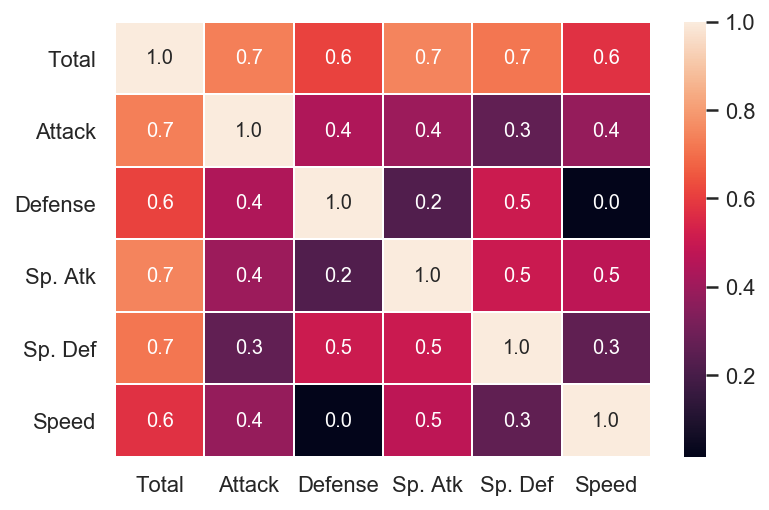

In [54]:
corr = train[linearity].corr()
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corr, annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

Total과 나머지 속성은 각각 (0.7, 0.6, 0.7, 0.7, 0.6)의 상관관계를 가진다.  
이 중 Attack을 제외하기로 한다.

---

# Fit & Predict

먼저 사용해야 할 컬럼을 추려내자.

In [55]:
print(train.columns, len(train.columns))

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'name_count',
       'long_name', 'name_isalpha', 'Size', 'Pumpkaboo', 'Gourgeist', 'Kyogre',
       'Kyurem', 'Forme', 'Charizard', 'Latias', 'Hoopa', 'Groudon', 'Deoxys',
       'Latios', 'Mega', 'Mewtwo', 'Rotom', 'Poison', 'Electric', 'Dark',
       'Water', 'Fighting', 'Flying', 'Ice', 'Ghost', 'Ground', 'Grass',
       'Steel', 'Psychic', 'Rock', 'Fairy', 'Bug', 'Fire', 'Dragon', 'Normal'],
      dtype='object') 49


이 중 제외해야 할 컬럼은 다음과 같다.

- `Name` : string 데이터로, 전처리를 통해 `name_count`와 `long_name`, 그리고 15개의 토큰 컬럼으로 대체되었다.
- `name_isalpha` : 전처리를 위해 필요했던 컬럼으로 분류 분석에는 필요하지 않다.
- `Type 1` & `Type 2` : 타입은 one-hot-encoding으로 처리했다.
- `Attack` : 선형 종속의 7가지 데이터 중 Attack을 제외하기로 했다.
- `Legendary` : target 데이터이므로 test 데이터로 쓴다.

In [56]:
features = ['#', 'Total', 'HP', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'name_count', 'long_name', \
            'Groudon', 'Gourgeist', 'Deoxys', 'Latios', 'Charizard', 'Mewtwo', 'Forme', 'Hoopa', 'Latias', 'Kyurem', 'Pumpkaboo', \
            'Kyogre', 'Mega', 'Size', 'Rotom', \
            'Ground', 'Psychic', 'Rock', 'Fighting', 'Ghost', 'Steel', 'Flying', 'Dark', 'Fire', 'Normal', 'Water', 'Ice', 'Bug', \
            'Grass', 'Poison', 'Fairy', 'Electric', 'Dragon']

len(features)

43

6개를 제외하고 43개가 남았다.

In [57]:
target = "Legendary"
target

'Legendary'

타겟은 Legendary이다.

이제 모델 생성을 위해 `X`, `y` 데이터를 생성한다.

In [58]:
X = train[features].reset_index()
print(X.shape)
X.head()

(800, 44)


,index,#,Total,HP,Defense,Sp. Atk,Sp. Def,Speed,Generation,name_count,...,Fire,Normal,Water,Ice,Bug,Grass,Poison,Fairy,Electric,Dragon
0,0,1,318,45,49,65,65,45,1,9,...,False,False,False,False,False,True,True,False,False,False
1,1,2,405,60,63,80,80,60,1,7,...,False,False,False,False,False,True,True,False,False,False
2,2,3,525,80,83,100,100,80,1,8,...,False,False,False,False,False,True,True,False,False,False
3,3,3,625,80,123,122,120,80,1,21,...,False,False,False,False,False,True,True,False,False,False
4,4,4,309,39,43,60,50,65,1,10,...,True,False,False,False,False,False,False,False,False,False


In [59]:
y = train[target]
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

이제 모델을 생성하기 위한 모든 준비가 마쳐졌다. **모델을 사용하러 가자!!!**

---

## Decision Tree

모델로는 sklearn 패키지의 DecisionTreeClassifier 모듈을 사용한다.

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
model = DecisionTreeClassifier(max_depth=5, random_state=0)
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

## Cross Validation

데이터셋은 train 데이터만 있고 test 데이터가 따로 없으므로 cross validation 방법을 이용해 모델을 검증하도록 하자.


Cross Validation을 위한 데이터셋은 sklearn 패키지의 KFold 모듈을 이용한다.

In [62]:
from sklearn.model_selection import KFold

cv를 통해 max_depth가 몇일 때 가장 좋은 성능을 보이는지 확인한다.

In [63]:
cv = KFold(5, shuffle=True, random_state=0)

cvs = []

# max_depth = 1 ~ 20
for i in range(1, 21):
    score = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        model = DecisionTreeClassifier(max_depth=i,random_state=0).fit(X_train, y_train)
        score.append(accuracy_score(y_test, model.predict(X_test)))
    cvs.append(np.round(sum(score) / 5, 4))

    
cvs[:5], len(cvs)

([0.9388, 0.9712, 0.9675, 0.9575, 0.9675], 20)

max_depth를 1부터 20까지 설정하며 cv를 실행하였고, 이를 그래프로 나타내서 확인해보자.

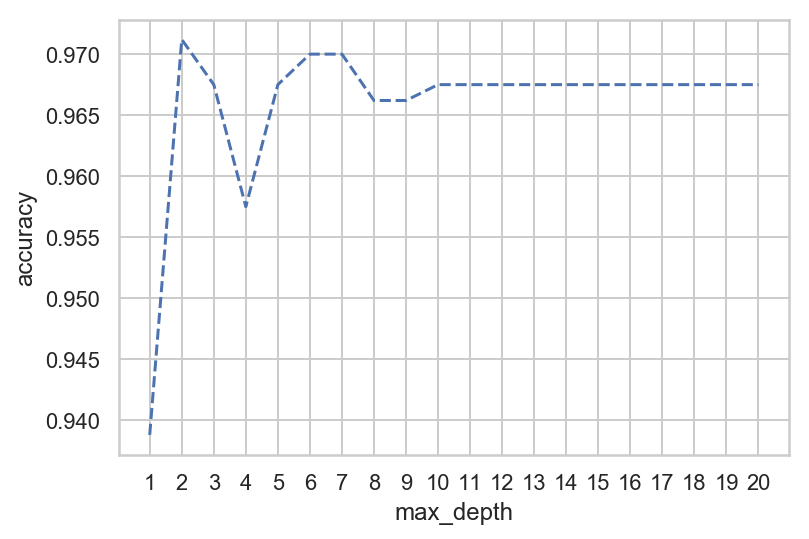

In [64]:
xx = ["{}".format(i) for i in range(1, 21)]
plt.plot(xx, cvs, "--")
ax.set_ylim([0.96, 1])
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.show()

max_depth가 얼마일 때 최대의 accuracy를 갖는지 확인해보자.

In [65]:
cvs.index(max(cvs)) + 1, max(cvs)

(2, 0.9712)

즉, **max_depth가 2인 경우 0.9712의 정확성을 보인다.**

max_depth가 2일 때 `classification report`와 `confusion matrix`로도 확인해보자.

In [66]:
for train_idx, test_idx in cv.split(X):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    model = DecisionTreeClassifier(max_depth=2,random_state=2).fit(X_train, y_train)

마지막 모델의 `confusion_matrix`와 `classification_report`는 다음과 같다.

In [67]:
confusion_matrix(y_test, model.predict(X_test))

array([[145,   2],
       [  0,  13]], dtype=int64)

In [68]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99       147
        True       0.87      1.00      0.93        13

   micro avg       0.99      0.99      0.99       160
   macro avg       0.93      0.99      0.96       160
weighted avg       0.99      0.99      0.99       160



꽤 좋은 모델이군!

---

# 전처리 없이 그냥 모델돌려보기

In [28]:
train = pd.read_csv("pokemon.csv")
print(train.shape)
train.head()

(800, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


#### Type만 전처리

In [29]:
# 모든 타입을 types 변수에 저장
types = list(set(train["Type 1"]))
print(types)

['Ground', 'Ghost', 'Psychic', 'Poison', 'Normal', 'Ice', 'Fire', 'Fighting', 'Rock', 'Grass', 'Electric', 'Water', 'Dragon', 'Flying', 'Bug', 'Steel', 'Dark', 'Fairy']


In [30]:
for type_ in types:
    train[type_] = (train["Type 1"] == type_) | (train["Type 2"] == type_)
    
train[[["Type 1", "Type 2"] + types][0]].head()

,Type 1,Type 2,Ground,Ghost,Psychic,Poison,Normal,Ice,Fire,Fighting,Rock,Grass,Electric,Water,Dragon,Flying,Bug,Steel,Dark,Fairy
0,Grass,Poison,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,Grass,Poison,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,Grass,Poison,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,Grass,Poison,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,Fire,NaN,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [31]:
print(train.columns, len(train.columns))

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'Ground',
       'Ghost', 'Psychic', 'Poison', 'Normal', 'Ice', 'Fire', 'Fighting',
       'Rock', 'Grass', 'Electric', 'Water', 'Dragon', 'Flying', 'Bug',
       'Steel', 'Dark', 'Fairy'],
      dtype='object') 31


In [32]:
features = ['#', 'Total', 'HP', 'Attack', 'Defense',\
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'Ground',\
       'Ghost', 'Psychic', 'Poison', 'Normal', 'Ice', 'Fire', 'Fighting',\
       'Rock', 'Grass', 'Electric', 'Water', 'Dragon', 'Flying', 'Bug',\
       'Steel', 'Dark', 'Fairy']

X = train[features].reset_index(drop=True)
print(X.shape)
X.head()

(800, 28)


,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,...,Rock,Grass,Electric,Water,Dragon,Flying,Bug,Steel,Dark,Fairy
0,1,318,45,49,49,65,65,45,1,False,...,False,True,False,False,False,False,False,False,False,False
1,2,405,60,62,63,80,80,60,1,False,...,False,True,False,False,False,False,False,False,False,False
2,3,525,80,82,83,100,100,80,1,False,...,False,True,False,False,False,False,False,False,False,False
3,3,625,80,100,123,122,120,80,1,False,...,False,True,False,False,False,False,False,False,False,False
4,4,309,39,52,43,60,50,65,1,False,...,False,False,False,False,False,False,False,False,False,False


In [33]:
y = train["Legendary"]
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

In [34]:
from sklearn.model_selection import KFold

cv = KFold(5, shuffle=True, random_state=0)

cvs = []

# max_depth = 1 ~ 20
for i in range(1, 21):
    score = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        model = DecisionTreeClassifier(max_depth=i,random_state=0).fit(X_train, y_train)
        score.append(accuracy_score(y_test, model.predict(X_test)))
    cvs.append(np.round(sum(score) / 5, 4))

    
cvs[:5], len(cvs)

([1.0, 1.0, 1.0, 1.0, 1.0], 20)

In [35]:
for train_idx, test_idx in cv.split(X):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    model = DecisionTreeClassifier(max_depth=2,random_state=2).fit(X_train, y_train)

마지막 모델의 `confusion_matrix`와 `classification_report`는 다음과 같다.

In [36]:
confusion_matrix(y_test, model.predict(X_test))

array([[147,   0],
       [  0,  13]], dtype=int64)

In [37]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       147
        True       1.00      1.00      1.00        13

   micro avg       1.00      1.00      1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

